# Optimizer
This notebook handles running optimized ensemble analysis, specifically the Gingleator class from `gerrychain`. It takes in shapefiles that have already been run through `Ensemble Prep.ipynb`

In [47]:
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
import matplotlib.pyplot as plt

import gerrychain
from gerrychain.updaters import cut_edges, Tally
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.tree import recursive_tree_part
from functools import partial
import pandas as pd

from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random



### Add a file prepared for ensemble analysis (see Ensemble Prep.ipynb) as the arg for the gpd.read_file() func

In [48]:
state_gdf = gpd.read_file("South Dakota/SD_ready_4_ensemble/SD_ready_4_ensemble.shp")

Convert gdf to graph

In [49]:
state_graph = Graph.from_geodataframe(state_gdf)

/home/gabed/Documents/Fall_24/Math195/Final_Project/.conda/lib/python3.10/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


Setting up some initial variables that our partition object is going to want. Ensure that the population tolerance is changed in accordance with the laws of the state that you're trying to run an analysis for. Same for the district count of course.

In [50]:
tot_pop = sum([state_graph.nodes()[v]['P1_001N'] for v in state_graph.nodes()])
num_dist = 35
ideal_pop = tot_pop/num_dist
pop_tolerance = 0.07 #Sometiems has to be raised to an unreasonable level to work unfortunately
initial_plan = recursive_tree_part(state_graph, range(num_dist), ideal_pop, 'P1_001N', pop_tolerance, 100)

### Use a preexisting plan

**CHANGE FROM MARKDOWN TO PYTHON TO USE**

#Set up partition object
initial_partition = GeographicPartition(
    graph=state_graph, # dual graph
    assignment="district",
    updaters = { 
        "our cut edges": cut_edges, 
        "district population": Tally("P1_001N", alias = "district population"), 
        "district NAPOP": Tally("P1_005N", alias = "district NAPOP"),
        "district NAPOP_MIXED": Tally("P1_012N", alias = "district NAPOP_MIXED"),
        "R Votes": Tally("G20PRERTRU", alias = "R Votes"), 
        "D Votes": Tally("G20PREDBID", alias = "D Votes")
    }
) 

### Or make your own plan

In [51]:
initial_partition = Partition(
    graph=state_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "our cut edges": cut_edges, 
        "district population": Tally("P1_001N", alias = "district population"), 
        "district NAPOP": Tally("P1_005N", alias = "district NAPOP"),
        "district NAPOP_MIXED": Tally("P1_012N", alias = "district NAPOP_MIXED"),
        "R Votes": Tally("G20PRERTRU", alias = "R Votes"), 
        "D Votes": Tally("G20PREDBID", alias = "D Votes")
    }
) 

In [52]:
rw_proposal = partial(proposals.recom, ## how you choose a next districting plan
                      pop_col = "P1_001N", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

constraints = constraints.within_percent_of_ideal_population(initial_partition, pop_tolerance, "district population")


## Run Gingleator
See https://gerrychain.readthedocs.io/en/stable/user/optimizers/ for more information.
This is a class provided by gerrychain that is an optimization method meant to maximize for majority-minority district for a specfic minority group. Basically meant to test for the first of the Gingles criteria. Needless to say it's a useful tool for our purposes.

In [53]:
#Proposal function
gingles = Gingleator(
    rw_proposal,
    constraints,
    initial_partition,
    minority_pop_col="district NAPOP", #plug in our target minority (Native American by district)
    total_pop_col="district population", #Total population
    score_function=Gingleator.reward_partial_dist
)

# Running the Optimizer
Uses three seperate optimization methods which I explain more fully in the writeup.

In [54]:
total_steps = 30000

# Short Bursts
max_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(gingles.short_bursts(10, 3000, with_progress_bar=True)):
    max_scores_sb[i] = gingles.best_score
    scores_sb[i] = gingles.score(part)

# Simulated Annealing
max_scores_anneal = np.zeros(total_steps)
scores_anneal = np.zeros(total_steps)
for i, part in enumerate(
    gingles.simulated_annealing(
        total_steps,
        gingles.jumpcycle_beta_function(1000, 4000),
        beta_magnitude=500,
        with_progress_bar=True
    )
):
    max_scores_anneal[i] = gingles.best_score
    scores_anneal[i] = gingles.score(part)

# Tilted Runs
max_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(gingles.tilted_run(total_steps, 0.125, with_progress_bar=True)):
    max_scores_tilt[i] = gingles.best_score
    scores_tilt[i] = gingles.score(part)

100%|██████████| 30000/30000 [03:06<00:00, 160.62it/s]


Plotting our data and exporting the image

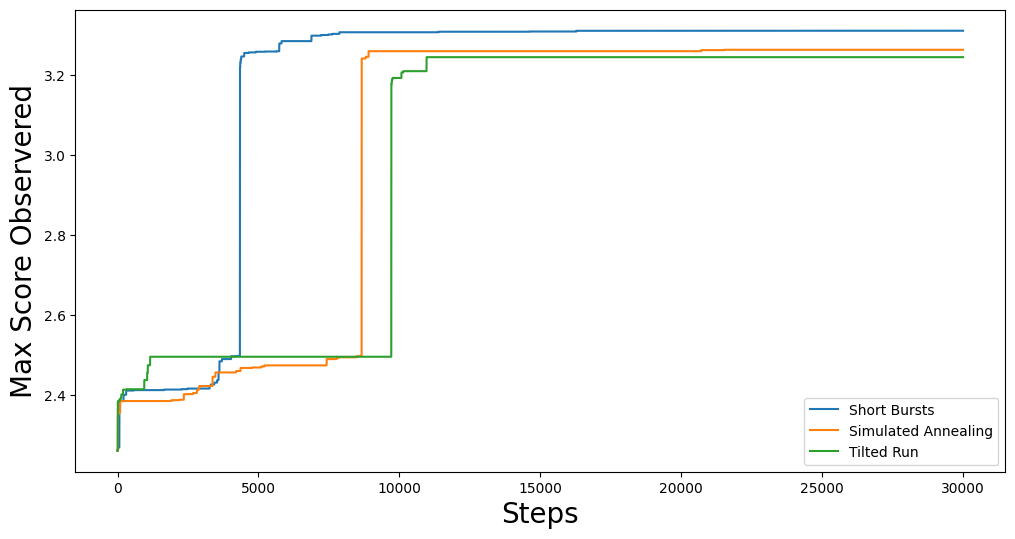

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(max_scores_sb, label="Short Bursts")
plt.plot(max_scores_anneal, label="Simulated Annealing")
plt.plot(max_scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Max Score Observered", fontsize=20)
plt.legend()



from pathlib import Path
Path("Plots/SD/ensemble/optimized/").mkdir(parents=True, exist_ok=True)

plt.savefig('Plots/SD/ensemble/optimized/native_single_optimized' + str(random.randint(1, 50000))) #random number to prevent overwrites 
plt.show()

